#### CAFA6-05-Model Improvement

This is a re-implementation of CAFA6-04

Future direction: Use model ensemble

References:
- https://www.kaggle.com/code/analyticaobscura/cafa-6-decoding-protein-mysteries
- (ESM-2 embeddings 320 features) https://www.kaggle.com/code/dalloliogm/compute-protein-embeddings-with-esm2-esm-c/notebook
- (MLP with ESM2) https://www.kaggle.com/code/jwang2025learning/cafa-6-function-prediction-using-prott5?scriptVersionId=282801093

---

In [1]:
!pip install biopython > /dev/null

## Step 1: Load CAFA6 files

---

In [2]:
from Bio import SeqIO  # parse fasta file
import pandas as pd
import numpy as np

In [3]:
# CAFA6 file paths
TRAIN_TERMS = "/kaggle/input/cafa-6-protein-function-prediction/Train/train_terms.tsv"
TRAIN_SEQ = "/kaggle/input/cafa-6-protein-function-prediction/Train/train_sequences.fasta"
TRAIN_TAXONOMY = "/kaggle/input/cafa-6-protein-function-prediction/Train/train_taxonomy.tsv"
TEST_SEQ = "/kaggle/input/cafa-6-protein-function-prediction/Test/testsuperset.fasta"

In [4]:
# Dict {entryId, seq}
train_sequences = {rec.id: str(rec.seq) for rec in SeqIO.parse(TRAIN_SEQ, 'fasta')}
test_sequences  = {rec.id: str(rec.seq) for rec in SeqIO.parse(TEST_SEQ,  'fasta')}

print(f'Loaded {len(train_sequences)} train and {len(test_sequences)} test sequences')

Loaded 82404 train and 224309 test sequences


In [5]:
print("Train dict:", list(train_sequences.items())[0])
print("Test dict:", list(test_sequences.items())[0])

Train dict: ('sp|A0A0C5B5G6|MOTSC_HUMAN', 'MRWQEMGYIFYPRKLR')
Test dict: ('A0A0C5B5G6', 'MRWQEMGYIFYPRKLR')


In [6]:
train_ids = [i.split('|')[1] for i in train_sequences.keys()]
test_ids = list(test_sequences.keys())

## Step 2: Feature extraction

We use the 20 features from the baseline
  
---

In [7]:
from collections import Counter

standard_aas = 'ACDEFGHIKLMNPQRSTVWY'  # 20 standard axit amin sequence characters

def extract_sequence_features(seq):
    """Convert a protein sequence into a 20-dim AAC vector."""
    length = len(seq)
    counts = Counter(seq)
    return np.array([counts.get(aa, 0) / length for aa in standard_aas])

In [8]:
X_train = np.array([extract_sequence_features(i) for i in train_ids])
print("X_train shape:", X_train.shape)
X_test = np.array([extract_sequence_features(i) for i in test_ids])
print("X_test shape:", X_test.shape)

X_train shape: (82404, 20)
X_test shape: (224309, 20)


## Step 3: Label encoding

For an MLP, we can just encode the label for each example as a (26125,) vector, as opposed to dividing it into three parts like when we used OneVsRest(LogisticRegression)

WHY?

Because LogisticRegression is a binary classifier, so it solves each label (out of 26125) separately when we use OneVsRestClassifier(LogisticRegression)

Whereas MLP solves everything at once

---

In [9]:
#Load GO term and aspects
train_terms = pd.read_csv(TRAIN_TERMS, sep="\t")

# Create multi-hot labels
go_terms = sorted(train_terms["term"].unique())
print("There are", len(go_terms), "unique GO terms")

go_terms_sorted = {go: i for i, go in enumerate(go_terms)}

# Build: EntryID → list of GO terms  
entry_to_gos = train_terms.groupby("EntryID")["term"].apply(list).to_dict()

There are 26125 unique GO terms


In [10]:
from scipy.sparse import lil_matrix
from tqdm import tqdm

y_train_sparse = lil_matrix((len(train_ids), len(go_terms)), dtype=np.int8)

for i in tqdm(range(len(train_ids)), desc="Encoding labels"):
    entry_id = train_ids[i]
    gos = entry_to_gos.get(entry_id, [])
    for go in gos:
        y_train_sparse[i, go_terms_sorted[go]] = 1

y_train_sparse = y_train_sparse.tocsr()
y_train = y_train_sparse

print("y_train shape:", y_train.shape)

Encoding labels: 100%|██████████| 82404/82404 [00:02<00:00, 39645.55it/s]

y_train shape: (82404, 26125)


## Step 4: Model training

In [11]:
import torch
import torch.nn as nn

class MLPClassifer(nn.Module):
    def __init__(self, input_dim=20, output_dim=26125):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(512, output_dim)   # no sigmoid here
        )

    def forward(self, x):
        return self.net(x)  # will apply sigmoid in loss

In [15]:
# Configuration
model = MLPClassifer(input_dim=X_train.shape[1], output_dim=y_train.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [12]:
# Train validation split
from sklearn.model_selection import train_test_split

train_idx, val_idx = train_test_split(
    np.arange(len(X_train)),
    test_size=0.1,
    random_state=42,
    shuffle=True
)

X_tr = X_train[train_idx]
X_val = X_train[val_idx]

y_tr = y_train[train_idx]
y_val = y_train[val_idx]

In [14]:
from torch.utils.data import DataLoader, TensorDataset

X_tr_tensor = torch.tensor(X_tr, dtype=torch.float32)
y_tr_tensor = torch.tensor(y_tr.toarray(), dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.toarray(), dtype=torch.float32)

train_loader = DataLoader(
    TensorDataset(X_tr_tensor, y_tr_tensor),
    batch_size=256,
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(X_val_tensor, y_val_tensor),
    batch_size=256,
    shuffle=False
)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

Epoch 1/10 - Train Loss: 0.0205 - Val Loss: 0.0021
Epoch 2/10 - Train Loss: 0.0020 - Val Loss: 0.0018
Epoch 3/10 - Train Loss: 0.0018 - Val Loss: 0.0018
Epoch 4/10 - Train Loss: 0.0018 - Val Loss: 0.0017
Epoch 5/10 - Train Loss: 0.0018 - Val Loss: 0.0017
Epoch 6/10 - Train Loss: 0.0018 - Val Loss: 0.0017
Epoch 7/10 - Train Loss: 0.0018 - Val Loss: 0.0017
Epoch 8/10 - Train Loss: 0.0018 - Val Loss: 0.0017
Epoch 9/10 - Train Loss: 0.0017 - Val Loss: 0.0017
Epoch 10/10 - Train Loss: 0.0017 - Val Loss: 0.0017


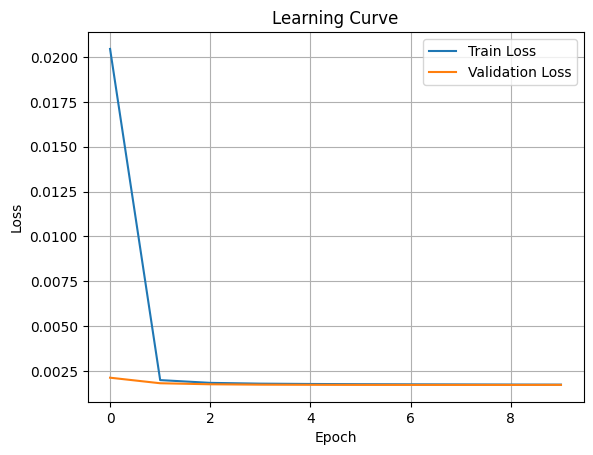

In [17]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Inspect output distribution on validation
model.eval()
all_probs = []
all_logits = []

with torch.no_grad():
    for X_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        logits = model(X_batch)
        all_logits.append(logits)
        probs = torch.sigmoid(logits).cpu().numpy()
        all_probs.append(probs)

Mean prob: 0.00024084315
Min prob: 4.4947175e-08
Max prob: 0.75705653
Median prob: 4.1530508e-05


In [ ]:
all_probs = np.concatenate(all_probs, axis=0)

print("Mean prob:", all_probs.mean())
print("Min prob:", all_probs.min())
print("Max prob:", all_probs.max())
print("Median prob:", np.median(all_probs))

In [19]:
logits_tensor = torch.cat(all_logits, dim=0)

logits = logits_tensor.cpu().numpy().flatten()

print("Logits mean:", logits.mean())
print("Logits std:", logits.std())
print("Min logit:", logits.min())
print("Max logit:", logits.max())

Logits mean: -9.838778
Logits std: 1.3448664
Min logit: -16.917778
Max logit: 1.1366091


In [25]:
for th in [0.001, 0.005, 0.01, 0.02]:
    print(th, (all_probs > th).sum())

0.001 6710565
0.005 933111
0.01 393956
0.02 168491


## Step 5: Inference and Submission

In [24]:
model.eval()
submission_list = []

BATCH_SIZE = 5000

with torch.no_grad():
    for i in tqdm(range(0, len(test_ids), BATCH_SIZE), desc="Predicting on Test Set"):
        
        # Load batch IDs
        batch_entry_ids = test_ids[i : i + BATCH_SIZE]

        # Slice features
        X_batch = X_test[i : i + BATCH_SIZE]
        X_batch = torch.tensor(X_batch, dtype=torch.float32, device=device)

        # Forward pass → logits → probabilities
        logits = model(X_batch)
        probs = torch.sigmoid(logits).cpu().numpy()   # (batch_size, num_go_terms)

        # For each protein in batch
        for j, entry_id in enumerate(batch_entry_ids):
            prob_vec = probs[j]

            # threshold at 0.02
            candidate_indices = np.where(prob_vec > 0.01)[0]

            for idx in candidate_indices:
                submission_list.append(
                    (entry_id, go_terms[idx], round(prob_vec[idx], 3))
                )

Predicting on Test Set: 100%|██████████| 45/45 [00:35<00:00,  1.27it/s]


In [26]:
submission_df = pd.DataFrame(
    submission_list,
    columns=['Protein Id', 'GO Term Id', 'Prediction']
)

submission_df = submission_df.sort_values(
    by=['Protein Id', 'Prediction'],
    ascending=[True, False]
)

# Limit 1500 predictions per protein
final_submission_df = (submission_df.groupby('Protein Id').head(1500).reset_index(drop=True))

final_submission_df.to_csv('submission.tsv', sep='\t', index=False, header=False)

In [27]:
print("\nSubmission file 'submission.tsv' created successfully.")
print(f"Total predictions in final submission: {len(final_submission_df):,}")
print("Submission DataFrame Head:")
display(final_submission_df.head())


Submission file 'submission.tsv' created successfully.
Total predictions in final submission: 10,275,758
Submission DataFrame Head:


,Protein Id,GO Term Id,Prediction
0,A0A017SE81,GO:0005515,0.248486
1,A0A017SE81,GO:0005634,0.088206
2,A0A017SE81,GO:0005829,0.069194
3,A0A017SE81,GO:0005737,0.064563
4,A0A017SE81,GO:0005886,0.061530
